In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import csv
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
%matplotlib inline

Using TensorFlow backend.


In [2]:
log_path = '/work/mwu3/drive_data/driving_log.csv'
data_folder = '/work/mwu3/drive_data/'

In [3]:
logs = []
with open(log_path,'rt') as f:
    reader = csv.reader(f)
    for line in reader:
        logs.append(line)
log_labels = logs.pop(0)

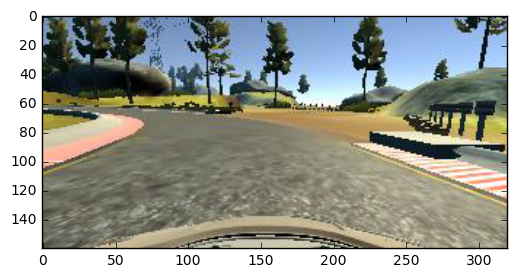

(160, 320, 3)


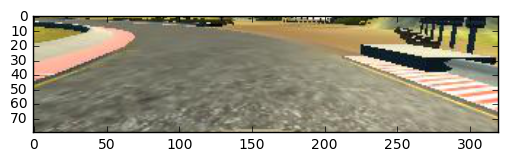

(80, 320, 3)


In [4]:
img = plt.imread(data_folder + (logs[10][0]).strip())
plt.imshow(img)
plt.show()
img_trimed = img[60:140]
print(img.shape)
plt.imshow(img_trimed)
plt.show()
print(img_trimed.shape)

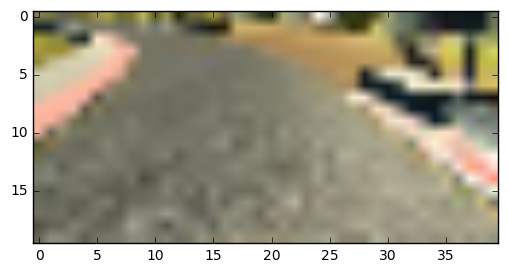

In [5]:
resized = resize(img_trimed,(20,40),order=1, preserve_range=True)
plt.imshow(resized.astype('uint8'))
plt.show()

In [6]:
def image_trim(img):
    trimed = img[60:140]
    resized = resize(trimed,(20,40),order=1, preserve_range=True)
    return resized

**load and trim image**

In [7]:
def load_data(X,y,data_folder,delta=0.08):
    log_path = data_folder + 'driving_log.csv'
    logs = []
    with open(log_path,'rt') as f:
        reader = csv.reader(f)
        for line in reader:
            logs.append(line)
        log_labels = logs.pop(0)
    
    for i in range(len(logs)):
        img_path = logs[i][0]
        img_path = data_folder+'IMG'+(img_path.split('IMG')[1]).strip()
        img = plt.imread(img_path)
        X.append(image_trim(img))
        y.append(float(logs[i][3]))

    for i in range(len(logs)):
        img_path = logs[i][1]
        img_path = data_folder+'IMG'+(img_path.split('IMG')[1]).strip()
        img = plt.imread(img_path)
        X.append(image_trim(img))
        y.append(float(logs[i][3]) + delta)

    for i in range(len(logs)):
        img_path = logs[i][2]
        img_path = data_folder+'IMG'+(img_path.split('IMG')[1]).strip()
        img = plt.imread(img_path)
        X.append(image_trim(img))
        y.append(float(logs[i][3]) - delta)

In [18]:
data={}
data['features'] = []
data['labels'] = []

load_data(data['features'], data['labels'],'/work/mwu3/drive_data/',0.06)
load_data(data['features'], data['labels'],'/work/mwu3/additional_data/',0.06)
load_data(data['features'], data['labels'],'/work/mwu3/recover_right/',0.06)

In [19]:
X_train = np.array(data['features']).astype('float32')
y_train = np.array(data['labels']).astype('float32')

**add more data by reflection**

In [20]:
X_train = np.append(X_train,X_train[:,:,::-1],axis=0)
y_train = np.append(y_train,-y_train,axis=0)

**split training validation and test **

In [21]:
X_train, y_train = shuffle(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.1)

In [22]:
print(X_train.shape)
print(X_val.shape)

(63277, 20, 40, 3)
(7031, 20, 40, 3)


In [23]:
img_size = X_train[0].shape
print(img_size)

(20, 40, 3)


**define model**

using comma.ai model (https://github.com/commaai/research/blob/master/train_steering_model.py)

In [24]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=img_size))
model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 20, 40, 3)     0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 5, 10, 16)     3088        lambda_2[0][0]                   
____________________________________________________________________________________________________
elu_5 (ELU)                      (None, 5, 10, 16)     0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 3, 5, 32)      12832       elu_5[0][0]                      
___________________________________________________________________________________________

**Train**

In [25]:
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train, y_train,batch_size=256, nb_epoch=10,verbose=1, validation_data=(X_val, y_val))

Train on 63277 samples, validate on 7031 samples
Epoch 1/10
63277/63277 [==============================] - 3s - loss: 0.0118 - val_loss: 0.0112
Epoch 2/10
63277/63277 [==============================] - 3s - loss: 0.0098 - val_loss: 0.0093
Epoch 3/10
63277/63277 [==============================] - 3s - loss: 0.0091 - val_loss: 0.0088
Epoch 4/10
63277/63277 [==============================] - 3s - loss: 0.0088 - val_loss: 0.0085
Epoch 5/10
63277/63277 [==============================] - 3s - loss: 0.0087 - val_loss: 0.0085
Epoch 6/10
63277/63277 [==============================] - 3s - loss: 0.0085 - val_loss: 0.0091
Epoch 7/10
63277/63277 [==============================] - 3s - loss: 0.0084 - val_loss: 0.0083
Epoch 8/10
63277/63277 [==============================] - 3s - loss: 0.0083 - val_loss: 0.0086
Epoch 9/10
63277/63277 [==============================] - 3s - loss: 0.0083 - val_loss: 0.0092
Epoch 10/10
63277/63277 [==============================] - 3s - loss: 0.0082 - val_loss: 0.0085


In [26]:
model.predict(X_train[0:10])

array([[ 0.0396724 ],
       [-0.07542747],
       [-0.1868768 ],
       [ 0.10279915],
       [-0.07662749],
       [ 0.11395953],
       [ 0.06596   ],
       [ 0.03944572],
       [ 0.00673018],
       [ 0.08817803]], dtype=float32)

In [27]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
